In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import os
import re
import math
import matplotlib.pyplot as plt

import sys
sys.path.append(r'../')

In [4]:
import gmsh
import pygmsh

from pyhmesh import BackgroundMesh
from pyhmesh import SurfaceMesh

In [21]:
def createModel():
    with pygmsh.occ.Geometry() as geom:
        Domain=geom.add_rectangle([0,0, 0.0], 20.0, 10.0)
        obj1=geom.add_rectangle([6,3, 0.0], 3, 6)
        obj2=geom.add_disk([14,5.0, 0.0],1,1)
        
        region=geom.boolean_difference(Domain,[obj1,obj2])
        geom.synchronize()

        geom.save_geometry('model_test.step')

In [22]:
createModel()

In [162]:
mesh = SurfaceMesh()
mesh.generate('model_test.step')

nodes,eles_bd = mesh.getMesh()

mesh.close()

Model dimension= 2
domain [<pygmsh Dummy object, ID 1>, <pygmsh Dummy object, ID 2>, <pygmsh Dummy object, ID 3>, <pygmsh Dummy object, ID 4>, <pygmsh Dummy object, ID 5>, <pygmsh Dummy object, ID 6>, <pygmsh Dummy object, ID 9>, <pygmsh Dummy object, ID 8>, <pygmsh Dummy object, ID 7>]
boundary [<pygmsh Dummy object, ID 1>, <pygmsh Dummy object, ID 2>, <pygmsh Dummy object, ID 3>, <pygmsh Dummy object, ID 4>, <pygmsh Dummy object, ID 5>, <pygmsh Dummy object, ID 6>, <pygmsh Dummy object, ID 9>, <pygmsh Dummy object, ID 8>, <pygmsh Dummy object, ID 7>]
Get nodes from 9 boundary entites
uint64 int64 137


In [164]:
faceTags=[i for i,e in enumerate(eles_bd) for j in range(len(e)) ]
eles = np.vstack(eles_bd)

In [166]:
import matplotlib
from matplotlib.collections import LineCollection,EllipseCollection


def plot_mesh(verts,edges,edge_scalar=None):
    #Plot throat size map
    ax=plt.gca()
    #Color edge by scalar (edge_scalar)
    
    if(edge_scalar is not None): 
        edge_scalar=np.array(edge_scalar)
        
        norm = plt.Normalize(np.min(edge_scalar), np.max(edge_scalar))
        coll = LineCollection(verts[edges,:], cmap='viridis', norm=norm, lw=0.8)
        coll.set_array(edge_scalar)
        lines=ax.add_collection(coll)
        fig.colorbar(lines, orientation='vertical',ax=ax)
    else:
        coll = matplotlib.collections.LineCollection(verts[edges,:], lw=0.8)
        lines=ax.add_collection(coll)
    ax.margins(0.05)

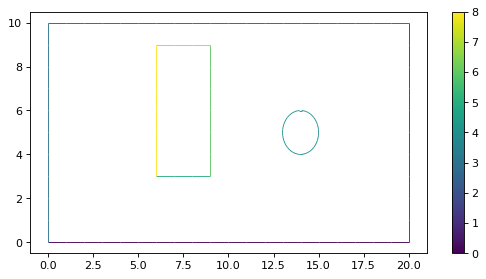

In [169]:
fig=plt.figure(figsize=(8, 4), dpi=80)
plot_mesh(nodes[:,0:2],eles,edge_scalar=faceTags)
plt.show()

In [80]:
eles

array([[  1,  19],
       [ 19,  20],
       [ 20,  21],
       [ 21,  22],
       [ 22,  23],
       [ 23,  24],
       [ 24,  25],
       [ 25,  26],
       [ 26,  27],
       [ 27,  28],
       [ 28,  29],
       [ 29,  30],
       [ 30,  31],
       [ 31,  32],
       [ 32,  33],
       [ 33,  34],
       [ 34,  35],
       [ 35,  36],
       [ 36,  37],
       [ 37,   2],
       [  2,  38],
       [ 38,  39],
       [ 39,  40],
       [ 40,  41],
       [ 41,  42],
       [ 42,  43],
       [ 43,  44],
       [ 44,  45],
       [ 45,  46],
       [ 46,   3],
       [  3,  47],
       [ 47,  48],
       [ 48,  49],
       [ 49,  50],
       [ 50,  51],
       [ 51,  52],
       [ 52,  53],
       [ 53,  54],
       [ 54,  55],
       [ 55,  56],
       [ 56,  57],
       [ 57,  58],
       [ 58,  59],
       [ 59,  60],
       [ 60,  61],
       [ 61,  62],
       [ 62,  63],
       [ 63,  64],
       [ 64,  65],
       [ 65,   4],
       [  4,  66],
       [ 66,  67],
       [ 67,

In [72]:
vtags

{126: 0,
 127: 1,
 128: 2,
 129: 3,
 130: 4,
 8: 5,
 6: 6,
 131: 7,
 132: 8,
 9: 9,
 133: 10,
 134: 11,
 135: 12,
 136: 13,
 137: 14,
 7: 15,
 124: 16,
 125: 17,
 75: 18,
 76: 19,
 77: 20,
 78: 21,
 79: 22,
 80: 23,
 81: 24,
 82: 25,
 83: 26,
 84: 27,
 85: 28,
 86: 29,
 87: 30,
 88: 31,
 89: 32,
 90: 33,
 91: 34,
 92: 35,
 93: 36,
 94: 37,
 95: 38,
 96: 39,
 97: 40,
 98: 41,
 99: 42,
 100: 43,
 101: 44,
 102: 45,
 103: 46,
 104: 47,
 105: 48,
 106: 49,
 107: 50,
 108: 51,
 109: 52,
 110: 53,
 111: 54,
 112: 55,
 113: 56,
 114: 57,
 115: 58,
 116: 59,
 117: 60,
 118: 61,
 119: 62,
 120: 63,
 121: 64,
 122: 65,
 123: 66,
 5: 67,
 66: 68,
 67: 69,
 68: 70,
 69: 71,
 70: 72,
 71: 73,
 72: 74,
 73: 75,
 74: 76,
 4: 77,
 1: 78,
 47: 79,
 48: 80,
 49: 81,
 50: 82,
 51: 83,
 52: 84,
 53: 85,
 54: 86,
 55: 87,
 56: 88,
 57: 89,
 58: 90,
 59: 91,
 60: 92,
 61: 93,
 62: 94,
 63: 95,
 64: 96,
 65: 97,
 3: 98,
 38: 99,
 39: 100,
 40: 101,
 41: 102,
 42: 103,
 43: 104,
 44: 105,
 45: 106,
 46: 107,


In [66]:
eles

array([[  1,  19],
       [ 19,  20],
       [ 20,  21],
       [ 21,  22],
       [ 22,  23],
       [ 23,  24],
       [ 24,  25],
       [ 25,  26],
       [ 26,  27],
       [ 27,  28],
       [ 28,  29],
       [ 29,  30],
       [ 30,  31],
       [ 31,  32],
       [ 32,  33],
       [ 33,  34],
       [ 34,  35],
       [ 35,  36],
       [ 36,  37],
       [ 37,   2],
       [  2,  38],
       [ 38,  39],
       [ 39,  40],
       [ 40,  41],
       [ 41,  42],
       [ 42,  43],
       [ 43,  44],
       [ 44,  45],
       [ 45,  46],
       [ 46,   3],
       [  3,  47],
       [ 47,  48],
       [ 48,  49],
       [ 49,  50],
       [ 50,  51],
       [ 51,  52],
       [ 52,  53],
       [ 53,  54],
       [ 54,  55],
       [ 55,  56],
       [ 56,  57],
       [ 57,  58],
       [ 58,  59],
       [ 59,  60],
       [ 60,  61],
       [ 61,  62],
       [ 62,  63],
       [ 63,  64],
       [ 64,  65],
       [ 65,   4],
       [  4,  66],
       [ 66,  67],
       [ 67,

In [57]:
gmsh.model.mesh.renumberNodes()

array([[ 6.        ,  8.        ,  0.        ],
       [ 6.        ,  7.        ,  0.        ],
       [ 6.        ,  6.        ,  0.        ],
       [ 6.        ,  5.        ,  0.        ],
       [ 6.        ,  4.        ,  0.        ],
       [ 6.        ,  9.        ,  0.        ],
       [ 6.        ,  3.        ,  0.        ],
       [ 8.        ,  9.        ,  0.        ],
       [ 7.        ,  9.        ,  0.        ],
       [ 9.        ,  9.        ,  0.        ],
       [ 9.        ,  4.        ,  0.        ],
       [ 9.        ,  5.        ,  0.        ],
       [ 9.        ,  6.        ,  0.        ],
       [ 9.        ,  7.        ,  0.        ],
       [ 9.        ,  8.        ,  0.        ],
       [ 9.        ,  3.        ,  0.        ],
       [ 7.        ,  3.        ,  0.        ],
       [ 8.        ,  3.        ,  0.        ],
       [14.9921147 ,  5.12533323,  0.        ],
       [14.96858316,  5.24868989,  0.        ],
       [14.92977649,  5.36812455,  0.   

In [14]:
background_mesh = BackgroundMesh('model_test.step')

Model filename= model_test.step
Model dimension= 2
Model bbox=
   (array([-1.e-07, -1.e-07, -1.e-07]), array([2.00000001e+01, 1.00000001e+01, 1.00000000e-07]))
Background mesh bbox (expanded by 0.2)=
   [array([-4.00000014, -2.00000014,  0.        ]), array([24.00000014, 12.00000014,  0.        ])]


In [15]:
background_mesh.setField(dx=0.3)

Set size field with dimension= [93 46] cell size= 0.3


In [16]:
background_mesh.hfield

array([[ 1.36052973e-311,  1.36052978e-311,  2.12199579e-314, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -4.85117669e+271,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [123]:
background_mesh = BackgroundMesh('fillet.geo')

Model filename= fillet.geo
Model dimension= 3
Model bbox=
   (array([-1.e-07, -1.e-07, -1.e-07]), array([1.0000001, 1.0000001, 1.0000001]))
Background mesh bbox (expanded by 0.2)=
   [array([-0.20000014, -0.20000014, -0.20000014]), array([1.20000014, 1.20000014, 1.20000014])]


In [32]:
with pygmsh.occ.Geometry() as geom:
    Domain=geom.add_rectangle([0,0, 0.0], 20.0, 10.0)
    obj1=geom.add_rectangle([6,3, 0.0], 3, 6)

In [ ]:
geom.synchronize()

In [349]:
def getBoundaryCurvature(fname, nd):
    #Get the boundary mesh curvature using gmsh
    with pygmsh.occ.Geometry() as geom:
        gmsh.merge(fname)
        print('Model filename=',fname)


        dim = gmsh.model.getDimension()
        dim_orig = dim #used for 2d model
        print("Model dimension=",dim)

        #Get all regions from CAD
        domain=gmsh.model.get_entities(dim)
        domain=gmsh2pygmsh(domain)
        
        bbox = getBbox(bds)
        model_length = np.linalg.norm(bbox[1]-bbox[0])

        gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", nd)
        gmsh.option.setNumber("Mesh.MeshSizeMax", model_length/20)

        #For 2d model, we need to convert it into 3d
        if(dim==2):
            top, vol_thick, lateral=geom.extrude(bds ,[0, 0, -model_length/20],num_layers=1)    
            dim=3
            gmsh.model.occ.synchronize()
        
        #generate boundary mesh only
        gmsh.model.mesh.generate(dim-1)

        #gmsh.fltk.run()
        
        #Get node-wise curvaure on the boundary
        bd_dim = dim - 1 
        ent = gmsh.model.getEntities(bd_dim)

        nodes=[]
        normals=[]
        curvatures=[]
        for dim,tag in ent:
            #nodes on boundary
            tags, coord, param = gmsh.model.mesh.getNodes(dim, tag, True)
            normal = gmsh.model.getNormal(tag, param)
            curv = gmsh.model.getCurvature(dim, tag, param)

            nodes+=[coord.reshape(-1,3)]
            normals+=[normal.reshape(-1,3)]
            curvatures+=list(curv)

        nodes=np.vstack(nodes)
        normals=np.vstack(normals)
        curvatures=np.array(curvatures)
        print(nodes.shape,normals.shape,curvatures.shape)
        print('Curvature range=',np.min(curvatures),np.max(curvatures))

        if(dim_orig==2):
            mask = nodes[:,2]>-1e-5
            print(mask.shape,np.sum(mask))
            return nodes[mask,:], curvatures[mask]

        return nodes,curvatures



def hcurv(background_mesh, nd):
    #curvature size field
    #nd = the number of elements nd used to accurately discretize a complete circle
    bd_nodes,curvs = getBoundaryCurvature(background_mesh.fname, nd=nd)

    #flat region has zero curvature
    curve_bd = curvs > 1e-3

    curvs[~curve_bd]=-1
    hcurv = 2*np.pi/curvs/nd
    min_hcurv,max_hcurv = np.min(hcurv[curve_bd]),np.max(hcurv[curve_bd])
    print('Curvature size field range=',min_hcurv,max_hcurv)

    if(min_hcurv<background_mesh.dx):
        background_mesh.setField(dx=min_hcurv*0.8)

    

In [42]:
background_mesh = Surface('model_test.step')

NameError: name 'Surface' is not defined

In [351]:
hcurv(background_mesh, nd=20)

Model filename= model_test.step
Model dimension= 2
(664, 3) (664, 3) (664,)
Curvature range= 0.0 0.3333333333333334
(664,) 332
Curvature size field range= 0.9424777960769377 0.9424777960769382
Set size field with dimension= [37 18] cell size= 0.7539822368615502


In [11]:
mesh = SurfaceMesh('model_test.step')

Model dimension= 2


In [ ]:
gmsh.model.occ.extrude()

In [38]:
mesh.close()

In [39]:
gmsh.fltk.run()

Exception: Could not get last error

In [ ]:
gmsh.finalize()

In [240]:
with pygmsh.occ.Geometry() as geom:
    #Create model using gmsh api
    gmsh.merge('model_test.step')


    dim = gmsh.model.getDimension()
    print("Model dimension=",dim)
    #Get all regions from CAD
    domain=gmsh.model.get_entities(dim)
    domain=gmsh2pygmsh(domain)

    bbox = getBbox(domain)
    long_edge = np.max(bbox[1]-bbox[0])
    print(bbox)

    if(dim==2):
        top, vol_thick, lateral=geom.extrude(domain ,[0, 0, -long_edge/10])    
        dim=3
    gmsh.model.occ.synchronize()
    
    gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 20)

    gmsh.model.mesh.generate(2)

    #gmsh.fltk.run()

    bd_dim = dim - 1 
    ent = gmsh.model.getEntities(bd_dim)

    nn = []
    cc = []
    for dim,tag in ent:
        print(dim,tag)
        tags, coord, param = gmsh.model.mesh.getNodes(dim, tag, True)
        normals = gmsh.model.getNormal(tag, param)
        curv = gmsh.model.getCurvature(dim, tag, param)
        print(len(coord)/3)

        for i in range(0, len(coord), 3):
            if(abs(normals[i + 2])>1e-5): continue
            if(coord[i + 2]<0): continue

            nn.append(coord[i])
            nn.append(coord[i + 1])
            nn.append(coord[i + 2])
            #print(coord[i],coord[i+1],coord[i+2])
            nn.append(normals[i])
            nn.append(normals[i + 1])
            nn.append(normals[i + 2])
            cc.append(coord[i])
            cc.append(coord[i + 1])
            cc.append(coord[i + 2])
            cc.append(curv[i // 3])


    t = gmsh.view.add("normals")
    gmsh.view.addListData(t, "VP", len(nn) // 6, nn)

    t = gmsh.view.add("curvatures")
    gmsh.view.addListData(t, "SP", len(cc) // 4, cc)

    gmsh.fltk.run()

Model dimension= 2
(array([-1.e-07, -1.e-07, -1.e-07]), array([2.00000001e+01, 1.00000001e+01, 1.00000000e-07]))
2 1
126.0
2 2
29.0
2 3
17.0
2 4
29.0
2 5
17.0
2 6
121.0
2 7
8.0
2 8
11.0
2 9
8.0
2 10
11.0
2 11
126.0


In [45]:
coord.reshape(-1,3)

array([[ 4.50148197e-01,  8.70554769e-02,  1.00000000e-01],
       [ 3.59539133e-01,  1.38985819e-01,  1.00000000e-01],
       [ 2.59803763e-01,  1.70881013e-01,  1.00000000e-01],
       [ 1.56783743e-01,  1.89913184e-01,  1.00000000e-01],
       [ 5.23911408e-02,  1.98899037e-01,  1.00000000e-01],
       [-5.23912146e-02,  1.98899034e-01,  1.00000000e-01],
       [-1.56783816e-01,  1.89913174e-01,  1.00000000e-01],
       [-2.59803835e-01,  1.70880996e-01,  1.00000000e-01],
       [-3.59539202e-01,  1.38985791e-01,  1.00000000e-01],
       [-4.50148254e-01,  8.70554299e-02,  1.00000000e-01],
       [-5.00000000e-01,  2.02127811e-16,  1.00000000e-01],
       [-4.50148197e-01, -8.70554769e-02,  1.00000000e-01],
       [-3.59539133e-01, -1.38985819e-01,  1.00000000e-01],
       [-2.59803763e-01, -1.70881013e-01,  1.00000000e-01],
       [-1.56783743e-01, -1.89913184e-01,  1.00000000e-01],
       [-5.23911408e-02, -1.98899037e-01,  1.00000000e-01],
       [ 5.23912146e-02, -1.98899034e-01

In [11]:
with pygmsh.occ.Geometry() as geom:

    gmsh.model.occ.addCircle(0, 0, 0, 0.5, 1)
    gmsh.model.occ.addCurveLoop([1], 1)
    gmsh.model.occ.addCircle(0.1, 0.05, 1, 0.1, 2)
    gmsh.model.occ.addCurveLoop([2], 2)
    gmsh.model.occ.addCircle(-0.1, -0.1, 2, 0.3, 3)
    gmsh.model.occ.addCurveLoop([3], 3)
    gmsh.model.occ.addThruSections([1, 2, 3], 1)
    gmsh.model.occ.synchronize()

    gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 20)
    #gmsh.option.setNumber("Mesh.MeshSizeMin", 0.001)
    #gmsh.option.setNumber("Mesh.MeshSizeMax", 0.3)


    bd_dim = 2
        
    gmsh.model.mesh.generate(bd_dim)



    ent = gmsh.model.getEntities(bd_dim)

    nn = []
    cc = []
    for dim,tag in ent:
        print(dim,tag)
        tags, coord, param = gmsh.model.mesh.getNodes(dim, tag, True)
        normals = gmsh.model.getNormal(tag, param)
        curv = gmsh.model.getCurvature(dim, tag, param)
        #print(normals,curv)

        for i in range(0, len(coord), 3):
            nn.append(coord[i])
            nn.append(coord[i + 1])
            nn.append(coord[i + 2])
            nn.append(normals[i])
            nn.append(normals[i + 1])
            nn.append(normals[i + 2])
            cc.append(coord[i])
            cc.append(coord[i + 1])
            cc.append(coord[i + 2])
            cc.append(curv[i // 3])


    t = gmsh.view.add("normals")
    gmsh.view.addListData(t, "VP", len(nn) // 6, nn)

    t = gmsh.view.add("curvatures")
    gmsh.view.addListData(t, "SP", len(cc) // 4, cc)
    gmsh.fltk.run()

2 1
2 2
2 3


In [27]:
gmsh.

Help on function add in module gmsh:

add(name, tag=-1)
    gmsh.view.add(name, tag=-1)
    
    Add a new post-processing view, with name `name'. If `tag' is positive use
    it (and remove the view with that tag if it already exists), otherwise
    associate a new tag. Return the view tag.
    
    Return an integer value.

